# Mappa colori dallo spettro ODMR

---

## Preparazione dei dati

Leggo direttamente dai file allineati e con background parzialmente rimosso.

In [29]:
from odmr_subroutines.analysis_subroutines import *
    
def build_name (dist):
    return f"data/cristallo2_aligned_cleaned/odmr_dist_{dist}_cleaned.csv"

distanze = [17, 19, 20, 22, 24, 30, 33, 39, 40, 1000]

Raccolgo tre colonne in ciascun file: freq, od, lock. Occhio: file diversi hanno colonne di lunghezze diverse. Occorre uniformare le lunghezze prima di fare la heatmap!

In [30]:
freq_data = []
spectra_data = []
lock_in_data = []

max_lenght = -10

for i, dist in enumerate( reversed(distanze) ):
    nome = build_name(dist)
    file = leggi_file_odmr(nome) 
    freq_data.append(file['freq'].tolist())
    spectra_data.append(file['od'].tolist())
    lock_in_data.append(file['lock'].tolist())
    
    if file['freq'].size > max_lenght:
        max_lenght = file['freq'].size
        idx_max_lenght = i

Prendo il file con le colonne più lunghe. Guardo gli estremi delle frequenze. Faccio in modo che tutti gli altri file abbiano lo stesso range di frequenze e lo stesso numero di punti, semplicemente aggiungendone tanti quanti ne servono. Le frequenze tanto vanno di 0.5 in 0.5; in od e lock metto un bello 0.

In [31]:
estremo_sx = freq_data[idx_max_lenght][0]
estremo_dx = freq_data[idx_max_lenght][-1]

for i in range(len(freq_data)):
    # controllo se la colonna corrente è più corta della più lunga
    if max_lenght > len(freq_data[i]):
        # allora controllo se manca qualcosa all'inizio:
        # (viene fuori che non è possibile: partono tutti da 2500.00)
        if freq_data[i][0] > estremo_sx:
            freq_data[i][0] = [estremo_sx + j*0.25 for j in range(int(round((freq_data[i][0] - estremo_sx)/0.25)) + 1)] + freq_data[i][0]
        # poi controllo se manca qualcosa alla fine:
        if freq_data[i][-1] < estremo_dx:
            freq_data[i] += [freq_data[i][-1] + j*0.25 for j in range(1, int(round((estremo_dx - freq_data[i][-1])/0.25)) + 1)]
            spectra_data[i] += [0.0 for _ in range(len(freq_data[i]) - len(spectra_data[i]))]
            lock_in_data[i] += [0.0 for _ in range(len(freq_data[i]) - len(lock_in_data[i]))]

        # infine, controllo che siano lunghi uguali!
        if max_lenght > len(freq_data[i]):
            print(f"ERRORE: la colonna {i} ({len(freq_data[i])}) è ancora più corta della più lunga ({max_lenght})!")


ERRORE: la colonna 0 (412) è ancora più corta della più lunga (865)!
ERRORE: la colonna 1 (855) è ancora più corta della più lunga (865)!
ERRORE: la colonna 2 (857) è ancora più corta della più lunga (865)!
ERRORE: la colonna 4 (859) è ancora più corta della più lunga (865)!
ERRORE: la colonna 5 (863) è ancora più corta della più lunga (865)!
ERRORE: la colonna 6 (859) è ancora più corta della più lunga (865)!
ERRORE: la colonna 7 (857) è ancora più corta della più lunga (865)!
ERRORE: la colonna 8 (855) è ancora più corta della più lunga (865)!
ERRORE: la colonna 9 (856) è ancora più corta della più lunga (865)!


In [32]:
def interpola_colonna_mancante(freq_orig, data_orig, freq_target_step=0.25):
    """Interpola una colonna con step più grandi su una griglia più fine"""
    
    # Crea la nuova griglia con step desiderato
    freq_min, freq_max = freq_orig[0], freq_orig[-1]
    n_points = int((freq_max - freq_min) / freq_target_step) + 1
    freq_new = np.linspace(freq_min, freq_max, n_points)
    
    # Interpolazione lineare
    data_new = np.interp(freq_new, freq_orig, data_orig)
    
    return freq_new.tolist(), data_new.tolist()

print("Lunghezze prima della correzione finale:")
for i in range(len(freq_data)):
    print(f"File {i}: {len(freq_data[i])} punti")

# FORZA tutte le colonne ad avere la stessa lunghezza
target_length = max(len(col) for col in freq_data)
print(f"Lunghezza target: {target_length}")

for i in range(len(freq_data)):
    if len(freq_data[i]) != target_length:
        print(f"Correggendo file {i}: da {len(freq_data[i])} a {target_length}")
        
        # Salva originali
        freq_orig = freq_data[i].copy()
        spectra_orig = spectra_data[i].copy()
        lock_orig = lock_in_data[i].copy()
        
        # Trova il file con lunghezza target come riferimento
        idx_target = next(j for j in range(len(freq_data)) if len(freq_data[j]) == target_length)
        freq_target = freq_data[idx_target]
        
        # Interpola su questa griglia
        spectra_new = np.interp(freq_target, freq_orig, spectra_orig)
        lock_new = np.interp(freq_target, freq_orig, lock_orig)
        
        # Sostituisci
        freq_data[i] = freq_target.copy()  # Usa le stesse frequenze
        spectra_data[i] = spectra_new.tolist()
        lock_in_data[i] = lock_new.tolist()

# Verifica finale
print("Lunghezze dopo correzione:")
for i in range(len(freq_data)):
    print(f"File {i}: freq={len(freq_data[i])}, spettro={len(spectra_data[i])}, lock={len(lock_in_data[i])}")


Lunghezze prima della correzione finale:
File 0: 412 punti
File 1: 855 punti
File 2: 857 punti
File 3: 865 punti
File 4: 859 punti
File 5: 863 punti
File 6: 859 punti
File 7: 857 punti
File 8: 855 punti
File 9: 856 punti
Lunghezza target: 865
Correggendo file 0: da 412 a 865
Correggendo file 1: da 855 a 865
Correggendo file 2: da 857 a 865
Correggendo file 4: da 859 a 865
Correggendo file 5: da 863 a 865
Correggendo file 6: da 859 a 865
Correggendo file 7: da 857 a 865
Correggendo file 8: da 855 a 865
Correggendo file 9: da 856 a 865
Lunghezze dopo correzione:
File 0: freq=865, spettro=865, lock=865
File 1: freq=865, spettro=865, lock=865
File 2: freq=865, spettro=865, lock=865
File 3: freq=865, spettro=865, lock=865
File 4: freq=865, spettro=865, lock=865
File 5: freq=865, spettro=865, lock=865
File 6: freq=865, spettro=865, lock=865
File 7: freq=865, spettro=865, lock=865
File 8: freq=865, spettro=865, lock=865
File 9: freq=865, spettro=865, lock=865


Riarrangio i dati

In [33]:
for i, dist in enumerate( reversed(distanze) ):
    spectra_data[i] = [spectra_data[i][j] if spectra_data[i][j] <= 0 else 0 for j in range(len(spectra_data[i]))]

In [34]:
dists = np.array(distanze[:-1]+[60]) # distanze, da cui poi ricaverò il campo B, ma lo faccio io dopo
freq_data_col = np.column_stack(freq_data)
Z_spectro = np.column_stack(spectra_data)
Z_lockin  = np.column_stack(lock_in_data)

In [35]:
import matplotlib.pyplot as plt
import numpy as np

### Heatmap spettro normale

#### In termini di campo magnetico e con i fit

In [36]:
popt_array = [np.array([1.57495217e+04, 2.84000000e+03, 1.01000000e+01, 1.00000000e-05]),
 np.array([1.22913046e+04, 2.87016764e+03, 1.01000000e+01, 4.94036954e-06]),
 np.array([5.9270686e+03, 2.8600000e+03, 1.0100000e+01, 1.0000000e-05]),
 np.array([2.45695531e+03, 2.86000000e+03, 1.01000000e+01, 1.00000000e-05]),
 np.array([4.000e+03, 2.865e+03, 9.900e+00, 1.000e-07]),
 np.array([8.62690181e+03, 2.85756739e+03, 1.01000000e+01, 2.58026122e-08]),
 np.array([1.25240765e+04, 2.85000000e+03, 9.90000000e+00, 1.60993301e-24]),
 np.array([1.5818071e+04, 2.8700000e+03, 1.0100000e+01, 1.0000000e-07]),
]
    

In [37]:
def funzione_fit_plus(B, gamma_fit, D):
    return D + np.sqrt(100 + (gamma_fit*B)**2)
def funzione_fit_minus(B, gamma_fit, D):
    return D - np.sqrt(100 + (gamma_fit*B)**2)

In [38]:
previsioni_B = np.array(list(reversed([0.01685433, 0.01270503, 0.01110222, 0.00857636, 0.00671791, 0.00345788, 0.00255966, 0.00147035, 0.00134735, 0])))*1000 # in mT

#### Aggiungo anche lo spettro a sinistra

In [39]:
nome = "data/cristallo2_aligned/odmr_dist_17.csv"
spettro = leggi_file_odmr(nome) 
popt0, fit_curve0 = fit_sin_odmr(spettro, 'od', fit_func=cub_func)
remove_background(spettro, 'od', fit_curve=fit_curve0, fit_func=cub_func, popt=popt0)

FUNZIONE DI FIT: cub_func
PARAMETRI FIT: [-1.22764609e-10  1.09550841e-06 -3.22999103e-03  4.38812854e+00]


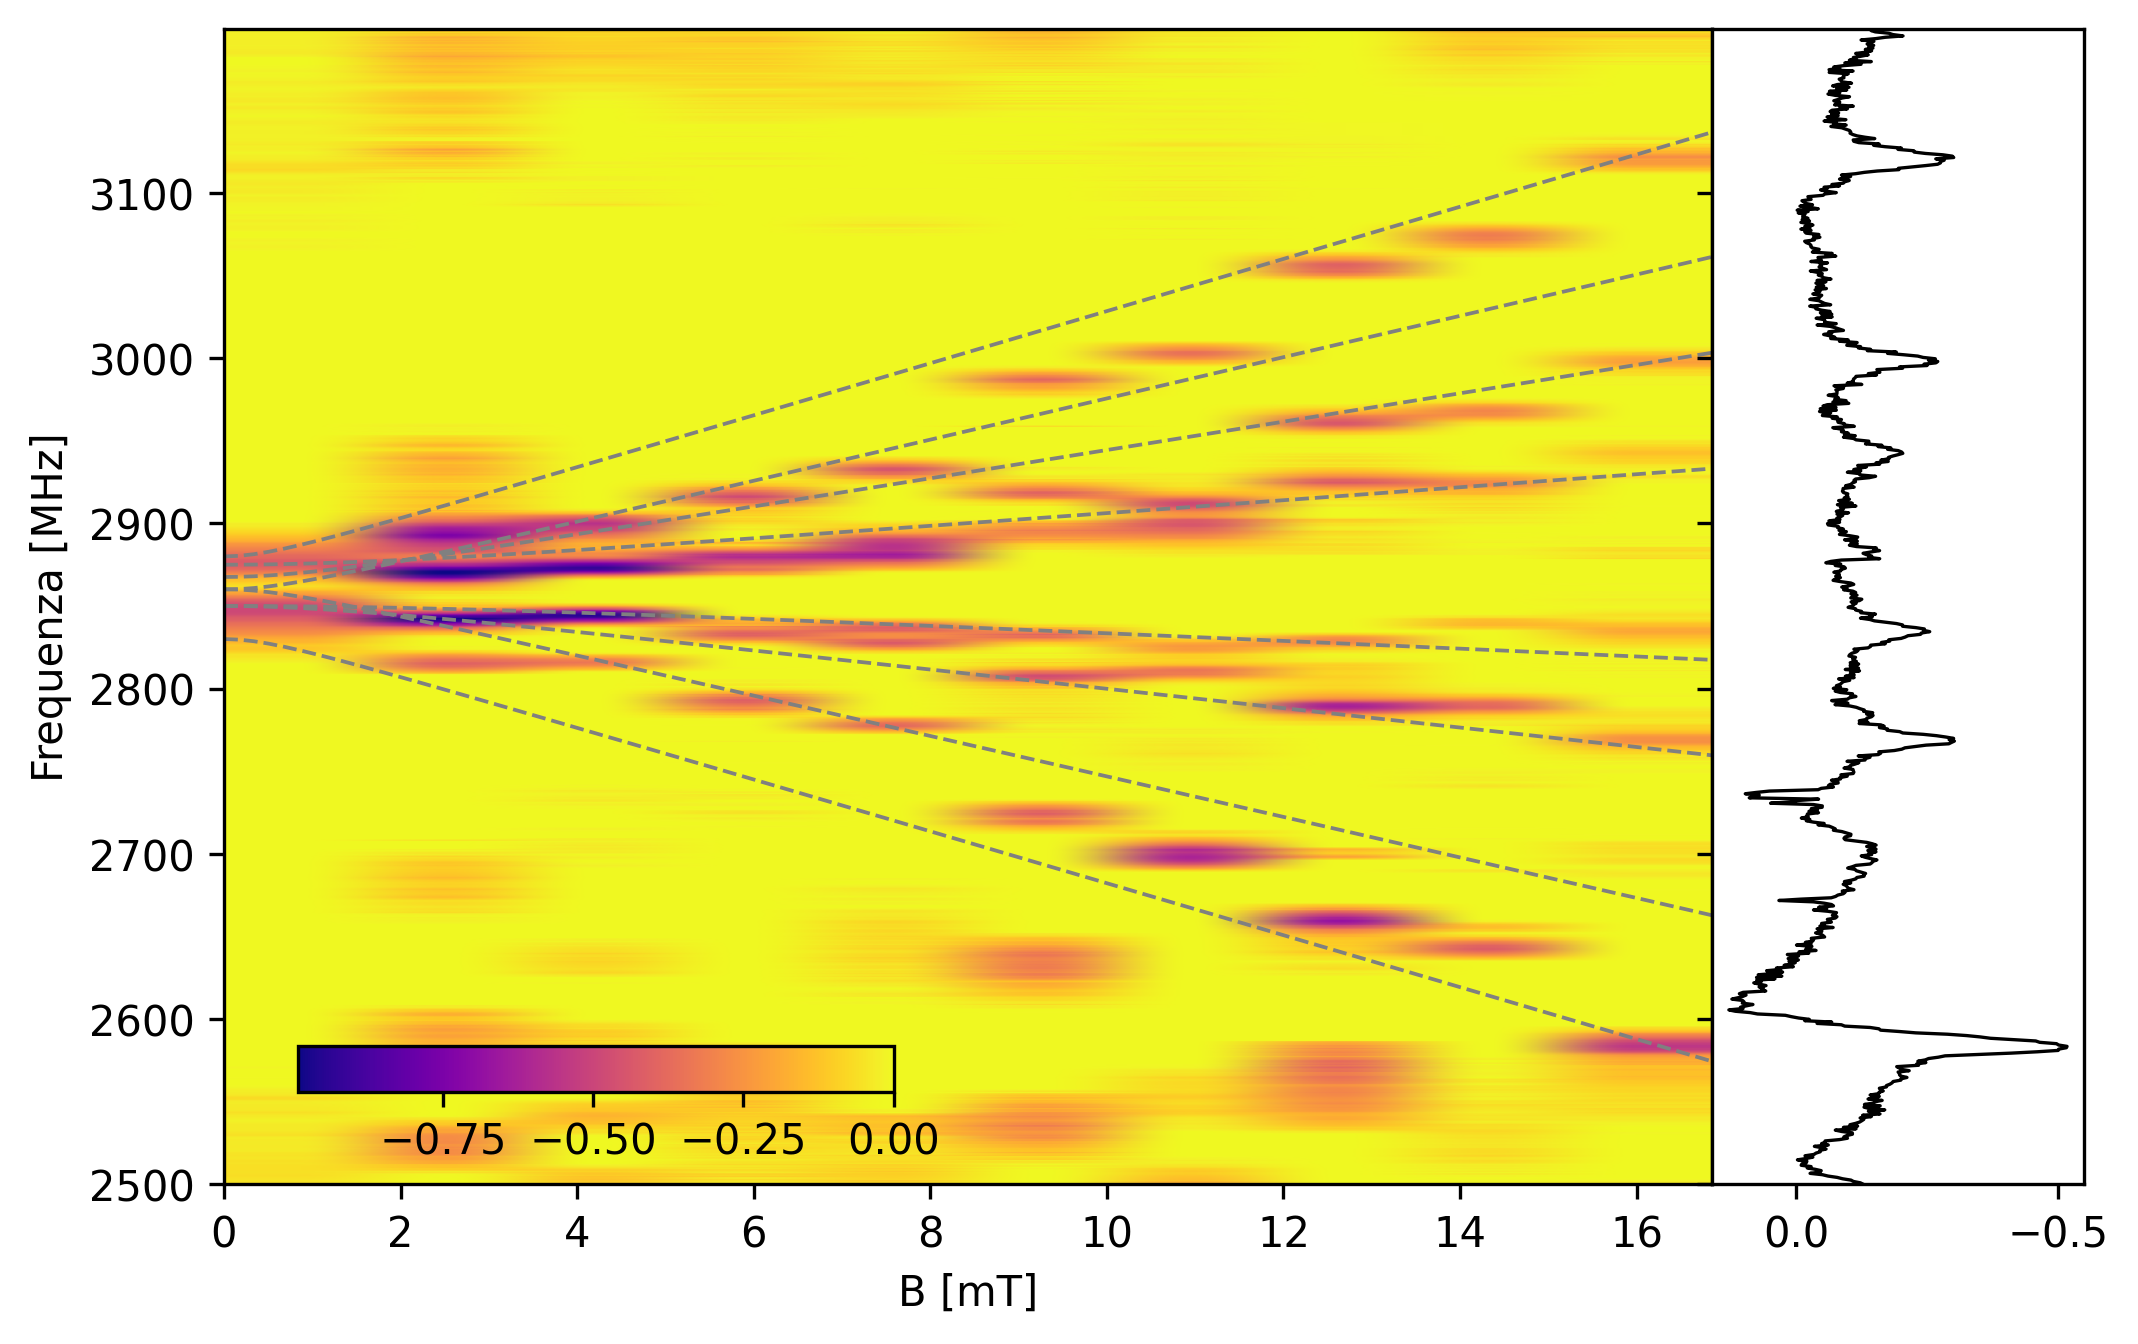

In [40]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Heatmap con spettro a sinistra - DIMENSIONI MODIFICATE
fig = plt.figure(figsize=(8, 5), dpi=300)  # CAMBIATO: da (10,4) a (8,5)

# Crea una griglia: 1 riga, 2 colonne con larghezze diverse - SPACING RIDOTTO
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1], wspace=0.0)  # CAMBIATO: da wspace=0.05 a 0.0
# Subplot per la heatmap (sinistra)
ax_heatmap = fig.add_subplot(gs[0, 0])
# Subplot per lo spettro (destra)
ax_spettro = fig.add_subplot(gs[0, 1])

# 1. SPETTRO A DESTRA (verticale)
y_axis = spettro['freq']  # frequenze
spettro_data = spettro['od']  # usa il primo spettro (o quello che vuoi)
ax_spettro.plot((spettro_data*50)-0.1, y_axis, 'k-', linewidth=0.8)
ax_spettro.set_ylim(y_axis[0], y_axis[-1])
ax_spettro.invert_xaxis()  # per avere l'origine a destra
#ax_spettro.grid(True, alpha=0.3)
ax_spettro.set_yticklabels([])

# 2. HEATMAP A SINISTRA (nuovo schema colori)
x_axis = previsioni_B
im = ax_heatmap.imshow(
    Z_spectro,
    aspect='auto',
    cmap='plasma',  # Prova questo invece di viridis
    extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]],
    origin='lower'
)

# 3. Curve sovrapposte
x_fit = np.linspace(x_axis[0], x_axis[-1], 100)
for i, popt in enumerate(popt_array):
    y_fit = funzione_fit_minus(x_fit, popt[0]/1000, popt[1]) if i < 4 else funzione_fit_plus(x_fit, popt[0]/1000, popt[1])
    ax_heatmap.plot(x_fit, y_fit, linestyle='--', color='grey', linewidth=0.9)

# 4. Labels
ax_heatmap.set_xlabel('B [mT]')
ax_heatmap.set_ylabel('Frequenza [MHz]')

# 5. COLORBAR ORIZZONTALE IN BASSO A SINISTRA
cax = inset_axes(ax_heatmap, 
                 width="40%",   # larghezza della colorbar
                 height="4%",   # altezza della colorbar
                 loc='lower left',
                 bbox_to_anchor=(0.05, 0.08, 1, 1),
                 bbox_transform=ax_heatmap.transAxes,
                 borderpad=0)

cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cax.patch.set_alpha(0.9)

plt.show()

---

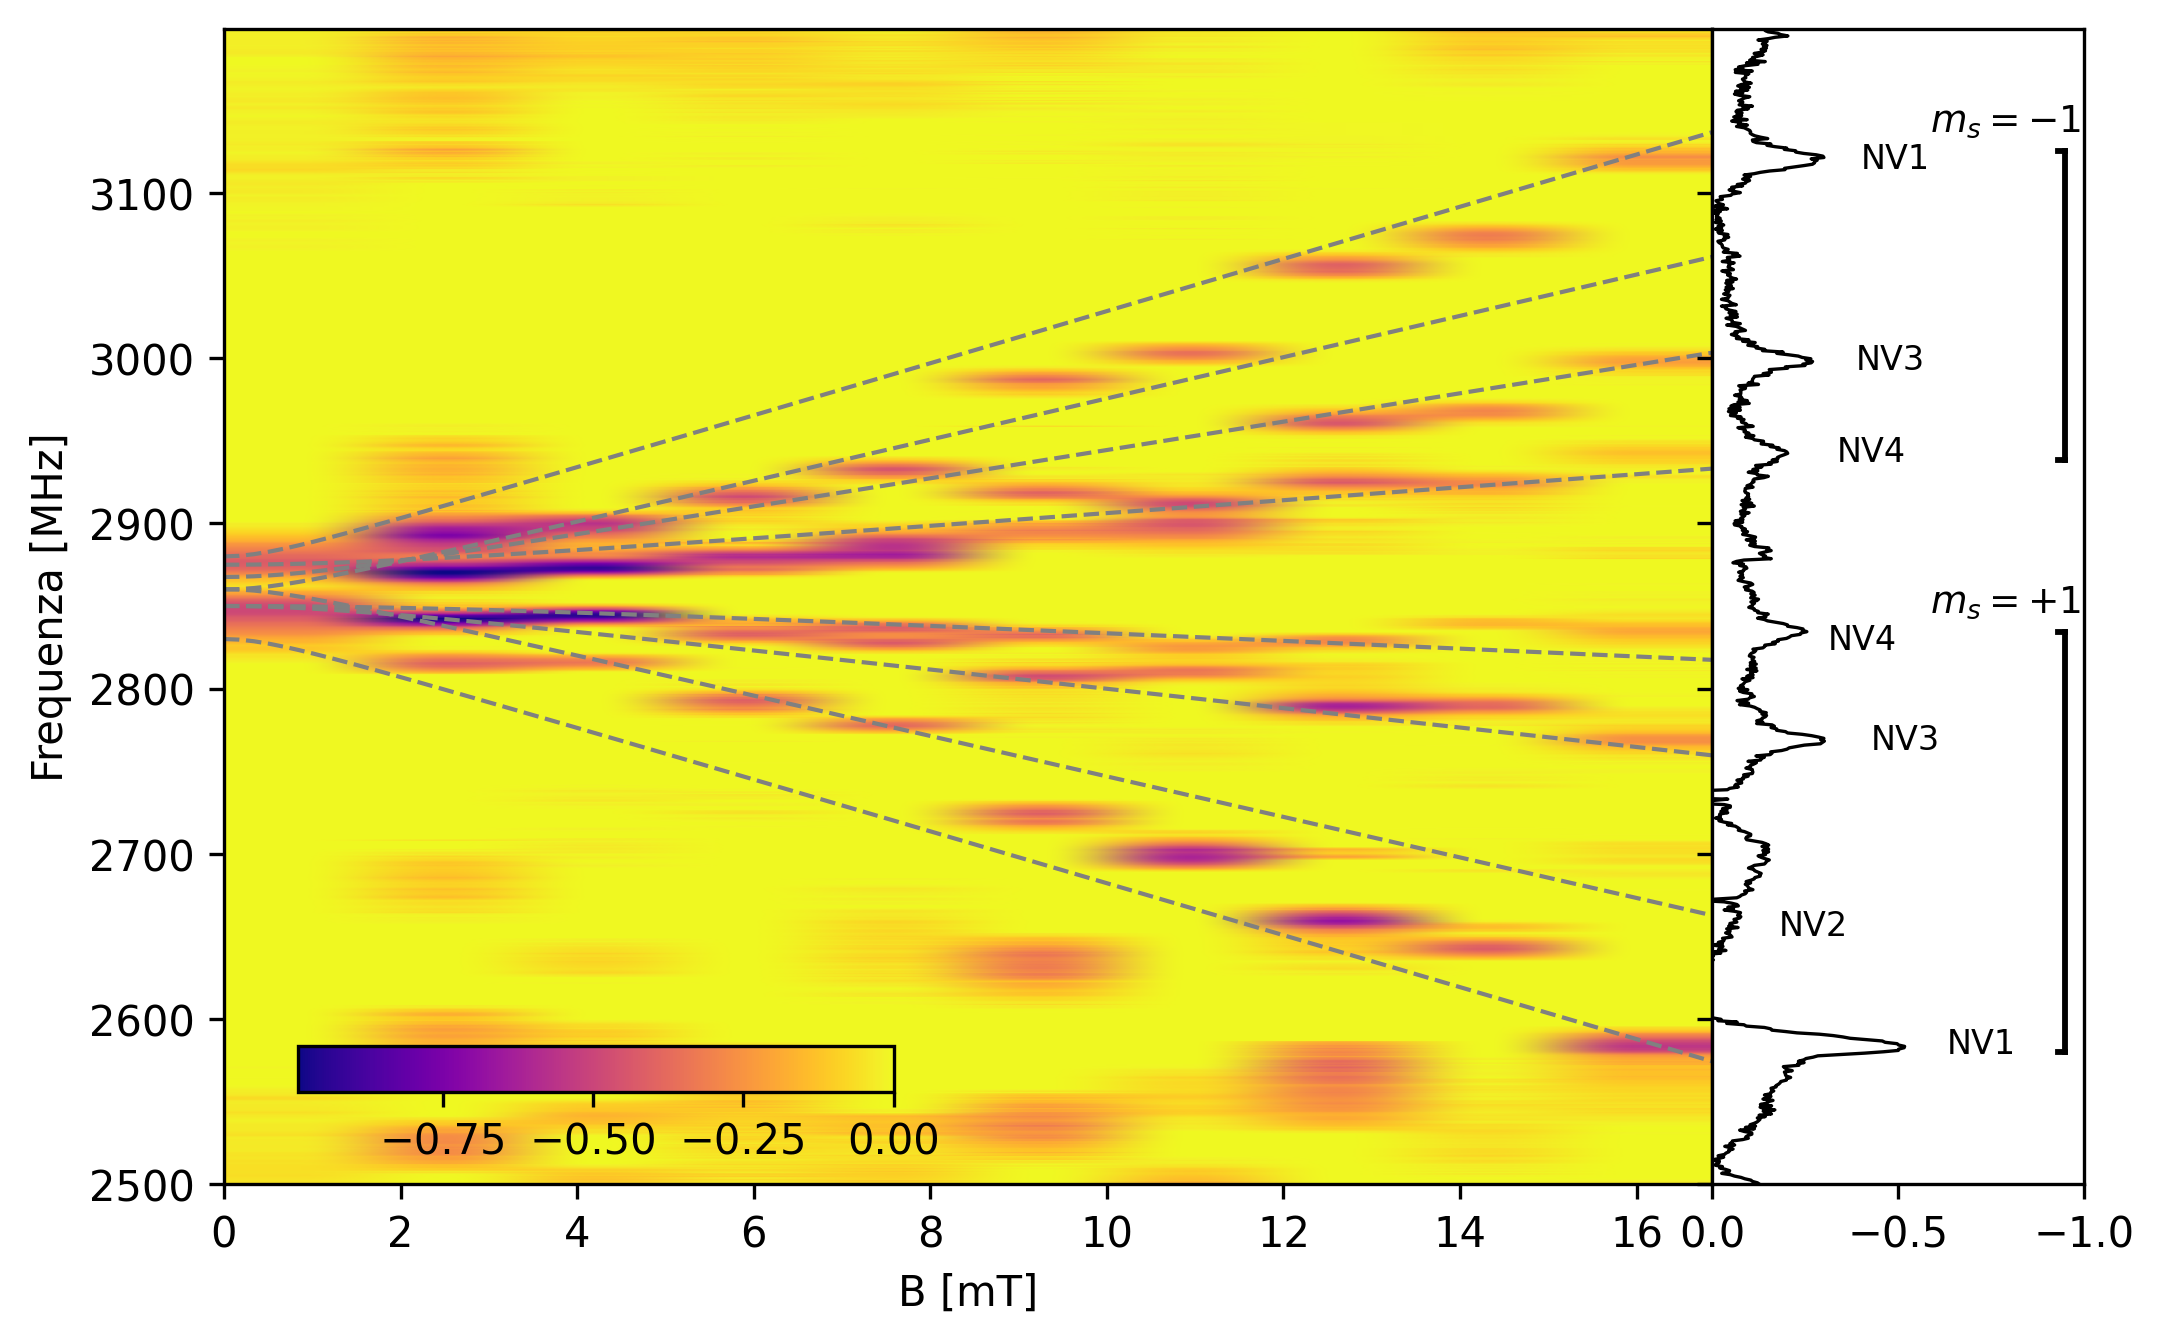

In [45]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.transforms as mtransforms

fig = plt.figure(figsize=(8, 5), dpi=300)
gs = fig.add_gridspec(1, 2, width_ratios=[4, 1], wspace=0.0)
ax_heatmap = fig.add_subplot(gs[0, 0])
ax_spettro = fig.add_subplot(gs[0, 1])

y_axis = spettro['freq']
spettro_data = spettro['od']
ax_spettro.plot((spettro_data*50)-0.1, y_axis, 'k-', linewidth=0.8)
ax_spettro.set_ylim(y_axis[0], y_axis[-1])
ax_spettro.set_xlim(-1, 0)
ax_spettro.invert_xaxis()
ax_spettro.set_yticklabels([])

# Deep + etichette NV
DeepMap = {
    'NV1': [2585., 3120.6],
    'NV2': [2656.],
    'NV3': [2769., 2999.],
    'NV4': [2829.5, 2943.4]
}
xlim = ax_spettro.get_xlim()
_dx = 0.27 * abs(xlim[1] - xlim[0])

for label, ylist in DeepMap.items():
    for y0_ in ylist:
        idx = int(np.argmin(np.abs(np.asarray(y_axis) - y0_)))
        x0 = (spettro_data[idx]*50)-0.15
        y_pt = y_axis[idx]
        # RIMOSSO il marker (pallino)
        ax_spettro.annotate(
            label,
            xy=(x0, y_pt), xycoords='data',
            xytext=(x0 - _dx, y_pt), textcoords='data',
            ha='right', va='center', fontsize=8, color='k', zorder=6,
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.8, boxstyle='round,pad=0.2'),
            #arrowprops=dict(arrowstyle='-', lw=0.6, color='k')
        )

# Graffe m_s
plus_group = [DeepMap['NV1'][0], DeepMap['NV2'][0], DeepMap['NV3'][0], DeepMap['NV4'][0]]
minus_group = [DeepMap['NV1'][1], DeepMap['NV3'][1], DeepMap['NV4'][1]]
yp_min, yp_max = min(plus_group)-5, max(plus_group)+5
ym_min, ym_max = min(minus_group)-5, max(minus_group)+5
y0, y1 = y_axis[0], y_axis[-1]
y_range = y1 - y0

trans = mtransforms.blended_transform_factory(ax_spettro.transAxes, ax_spettro.transData)
x_brace = 0.95
brace_tick = 0.02
x_label = min(0.995, x_brace + brace_tick + 0.015)
y_text_offset = 0.02 * y_range

# m_s=+1
ax_spettro.plot([x_brace, x_brace], [yp_min, yp_max], transform=trans, color='k', lw=1.4, clip_on=False)
ax_spettro.plot([x_brace, x_brace - brace_tick], [yp_min, yp_min], transform=trans, color='k', lw=1.4, clip_on=False)
ax_spettro.plot([x_brace, x_brace - brace_tick], [yp_max, yp_max], transform=trans, color='k', lw=1.4, clip_on=False)
ax_spettro.text(x_label-0.4, yp_max + y_text_offset/2, r'$m_s=+1$', transform=trans, va='bottom', ha='left', fontsize=9, clip_on=False)

# m_s=-1
ax_spettro.plot([x_brace, x_brace], [ym_min, ym_max], transform=trans, color='k', lw=1.4, clip_on=False)
ax_spettro.plot([x_brace, x_brace - brace_tick], [ym_min, ym_min], transform=trans, color='k', lw=1.4, clip_on=False)
ax_spettro.plot([x_brace, x_brace - brace_tick], [ym_max, ym_max], transform=trans, color='k', lw=1.4, clip_on=False)
ax_spettro.text(x_label-0.4, ym_max + y_text_offset/2, r'$m_s=-1$', transform=trans, va='bottom', ha='left', fontsize=9, clip_on=False)

# Heatmap
x_axis = previsioni_B
im = ax_heatmap.imshow(
    Z_spectro,
    aspect='auto',
    cmap='plasma',
    extent=[x_axis[0], x_axis[-1], y_axis[0], y_axis[-1]],
    origin='lower'
)

# Curve
x_fit = np.linspace(x_axis[0], x_axis[-1], 100)
for i, popt in enumerate(popt_array):
    y_fit = funzione_fit_minus(x_fit, popt[0]/1000, popt[1]) if i < 4 else funzione_fit_plus(x_fit, popt[0]/1000, popt[1])
    ax_heatmap.plot(x_fit, y_fit, linestyle='--', color='grey', linewidth=1)

ax_heatmap.set_xlabel('B [mT]')
ax_heatmap.set_ylabel('Frequenza [MHz]')

cax = inset_axes(ax_heatmap,
                 width="40%",
                 height="4%",
                 loc='lower left',
                 bbox_to_anchor=(0.05, 0.08, 1, 1),
                 bbox_transform=ax_heatmap.transAxes,
                 borderpad=0)
cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
cax.patch.set_alpha(0.9)

plt.show()